In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ds5230usml-project/Reviews.csv
/kaggle/input/ds5230usml-project/database.sqlite
/kaggle/input/ds5230usml-project/hashes.txt


In [185]:
# Importing libraries

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
#To track function execution
from tqdm import tqdm
from bs4 import BeautifulSoup

#Libraries for Sentimental analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Libraries for visualization
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

#Libraries for ML
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
# Reading dataframe
df = pd.read_csv("Reviews.csv")

In [3]:
#Looking at top 5 rows
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Not that we have 10 features and 568454 data points. There are some missing values in 'PROFILENAME' & 'SUMMARY' column. 

In [4]:
# Checking for null values in the dataframe.
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [5]:
# Inspecting entries with Null value in profileName column 
df[df["ProfileName"].isnull()]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
25509,25510,B000LKZB4Y,A36BVYD0NT7Z0F,NaN,0,0,5,1314576000,These are the best mints and no aspartame or BHT,I was so shocked to find out that almost all g...
38874,38875,B000AYDGZ2,A36BVYD0NT7Z0F,NaN,2,3,1,1278374400,doesn't anyone care that they are putting BHT ...,I called Kellogg's to see why Special K red be...
49800,49801,B000CRHQN0,A2LYFY32LXQDON,NaN,0,0,2,1282608000,They were melted and the chocolate had turned ...,We love these bars but i won't order them ship...
67077,67078,B0006348H2,A2P0P67Y55SNOX,NaN,1,1,5,1314662400,Wheatgrass,Kitty seems to like this sprinkled on her food...
106550,106551,B001EQ5DG0,A1P500QXEG3IUZ,NaN,0,0,5,1326758400,Finally!,"You cannot find this in the stores anymore, it..."
137613,137614,B000CQE3HS,AGT3BYX5P9SLH,NaN,0,0,5,1324684800,awesome,i love them they are amazing I would eat them ...
163191,163192,B000CQID1A,AGT3BYX5P9SLH,NaN,0,0,5,1324684800,awesome,i love them they are amazing I would eat them ...
172462,172463,B001FA1L9I,AC9U70TRGPDGJ,NaN,0,0,5,1289520000,very good,came in proper packaging. Have loved British ...
297275,297276,B007OXJM6E,A29D7XVSBCLFLD,NaN,0,0,1,1325203200,Burnt,The last SEVERAL time we bought this it tasted...
306751,306752,B000RI1W8E,AGT3BYX5P9SLH,NaN,0,0,5,1324684800,awesome,i love them they are amazing I would eat them ...


In [6]:
# Dropping Null values
df.dropna(inplace=True)

In [7]:
# Checking if null value exist again
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [8]:
# Checking the columns of the reviews.
df.columns


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [9]:
#Checking the shape of the dataframe.
df.shape

(568411, 10)

In [10]:
# Checking for the info of the dataframe.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568411 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568411 non-null int64
ProductId                 568411 non-null object
UserId                    568411 non-null object
ProfileName               568411 non-null object
HelpfulnessNumerator      568411 non-null int64
HelpfulnessDenominator    568411 non-null int64
Score                     568411 non-null int64
Time                      568411 non-null int64
Summary                   568411 non-null object
Text                      568411 non-null object
dtypes: int64(5), object(5)
memory usage: 47.7+ MB


In [11]:
# Statistical analysis of the dataframe.
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568411.000000,568411.000000,568411.000000,568411.000000,5.684110e+05
mean,284227.440964,1.743874,2.227876,4.183309,1.296261e+09
std,164099.020907,7.636781,8.288752,1.310368,4.803792e+07
min,1.000000,0.000000,0.000000,1.000000,9.393408e+08
25%,142114.500000,0.000000,0.000000,4.000000,1.271290e+09
50%,284224.000000,0.000000,1.000000,5.000000,1.311120e+09
75%,426341.500000,2.000000,2.000000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.000000,5.000000,1.351210e+09


In [12]:
# Checking number of reviews for each score.
df["Score"].value_counts()

5    363111
4     80655
1     52264
3     42638
2     29743
Name: Score, dtype: int64

# **Exploratory Data Analysis**

Note that more than 75% of our data is belonging to positive class(Score=4,5), i.e. we have imbalanced dataset.

In [13]:
total = df["Score"].count()
print(total)

568411


In [14]:
percent_plot = pd.DataFrame({"Total":df["Score"].value_counts()})
percent_plot.reset_index(inplace = True)
percent_plot.rename(columns={"index":"Rating"},inplace=True)

In [15]:
percent_plot

,Rating,Total
0,5,363111
1,4,80655
2,1,52264
3,3,42638
4,2,29743


Below is the plot of number of ratings each score has received.

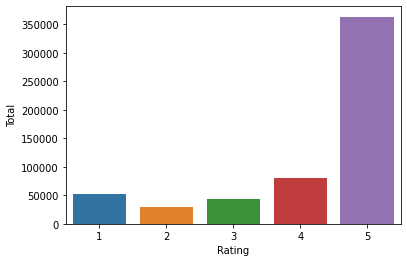

In [16]:
sns.barplot(x="Rating",y="Total", data=percent_plot)

In [17]:
percent_plot["Percent"] = percent_plot["Total"].apply(lambda x: (x/total)*100)

In [19]:
#percent_plot.drop(['percent'],axis=1, inplace = True)

We can see that 5-star reviews constitute a large proportion (63.88%) of all reviews. The next most prevalent rating is 4-stars(14.18%), followed by 1-star (9.19%), 3-star (7.50%), and finally 2-star reviews (5.23%).

In [20]:
percent_plot

,Rating,Total,Percent
0,5,363111,63.881769
1,4,80655,14.189557
2,1,52264,9.194755
3,3,42638,7.501262
4,2,29743,5.232657


Below is the plot of Ratings and its percentage.

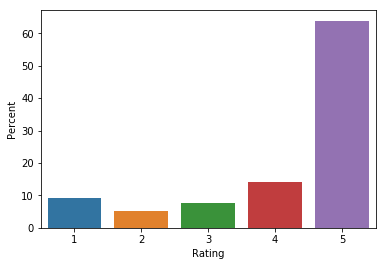

In [21]:
sns.barplot(x="Rating", y="Percent", data = percent_plot)

# **Text Exploration**

In [22]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [23]:
df["word_count"] = df["Text"].apply(lambda x: len(str(x).split(" ")))
df[["Text","word_count"]].head()

,Text,word_count
0,I have bought several of the Vitality canned d...,49
1,Product arrived labeled as Jumbo Salted Peanut...,31
2,This is a confection that has been around a fe...,99
3,If you are looking for the secret ingredient i...,43
4,Great taffy at a great price. There was a wid...,30


In [24]:
# Checking the statistics of word count to check for range and average number of the words in each article.
df["word_count"].describe()

count    568411.000000
mean         82.008950
std          80.808843
min           3.000000
25%          34.000000
50%          58.000000
75%         100.000000
max        3526.000000
Name: word_count, dtype: float64

In [25]:
#Checking for top 20 most repeated words - Gives insights on data specific stop words.

common_words = pd.Series(' '.join(df["Text"]).split()).value_counts()
common_words[:20]

the     1628022
I       1388024
and     1228619
a       1163101
to       992344
of       789642
is       714256
it       631240
for      519980
in       512386
this     488303
that     400460
my       364014
with     336238
have     335281
but      324902
are      310922
was      307851
not      285042
you      280381
dtype: int64

In [26]:
# Checking 20 most uncommon words
common_words[-20:]

1-5%               1
Yecccccccch.<br    1
Dr.<br             1
prebiotic.<br      1
bothered)          1
dark-mottled       1
5years.            1
Antwerp.           1
YAM.               1
Durkee's.          1
$3.63              1
was....Just        1
'aloe              1
"Helper            1
him/               1
gingko_bay         1
collie-mix.        1
mosy               1
pods'.             1
/>**Edit           1
dtype: int64

# **Text Preprocessing**

In [18]:
# Removing Stopwords
stop_words = set(stopwords.words("english"))

# Adding common words from our document to stop_words

add_words = ["the","I","and","a","to","of","is","it","for","in","this","that","my","with",     
"have",     
"but",      
"are",      
"was",      
"not",      
"you"]

stop_words = stop_words.union(add_words)

In [19]:
#Below Function is to clean the text and prepare it for the next phase.

from tqdm import tqdm
corpus = []

def clean_content(df):
    cleaned_content = []
    
    for sent in tqdm(df["Text"]):
        
        #Removing HTML comtent
        review_content = BeautifulSoup(sent).get_text()
        
        #Removing non-alphabetic charecters
        review_content = re.sub("[^a-zA-Z]"," ", review_content)
        
        #Tokenize the sentences
        words = word_tokenize(review_content.lower())
        
        #Removing the stop words
        sto_words_removed = [word for word in words if not word in stop_words]
        sto_words_removed = " ".join(sto_words_removed)
        corpus.append(sto_words_removed)
        cleaned_content.append(sto_words_removed)
        
    return (cleaned_content)

In [20]:
df["cleaned_text"] = clean_content(df)

100%|████████████████████████████████████████████████████████████████████████| 568411/568411 [08:31<00:00, 1111.43it/s]


In [21]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...


# **Data Exploration**

Building a wordcloud to visualize most frequently used words after Text pre-processing stage  

In [22]:
wordcloud = WordCloud(
                    background_color = "white",
                    stopwords = stop_words,
                    max_words = 100,
                    max_font_size = 50).generate(str(corpus))

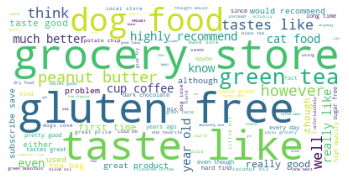

In [23]:
# Displaying the word cloud
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
#fig.savefig("word1.png", dpi=900)

# Tf-Idf

In [35]:
tf_idf_vect = TfidfVectorizer(ngram_range = (1,2))
tf_idf = tf_idf_vect.fit_transform(df_4000['cleaned_text'].values)

In [36]:
# Performing standard scaling
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean = False)
scaled_data = std.fit_transform(tf_idf) 

In [40]:
scaled_data = scaled_data.todense()

In [41]:
scaled_data.shape

(4000, 123549)

# Recommender System

In [49]:
rec_df = df[['ProductId', 'UserId','Score']]

In [50]:
rec_df.columns

Index(['ProductId', 'UserId', 'Score'], dtype='object')

In [51]:
# Finding the unique userId and ProductID
print("Number of unique users = ", df['UserId'].nunique())
print("Number of unique products = ", df['ProductId'].nunique())

Number of unique users =  256047
Number of unique products =  74258


In [52]:
# Score description
rec_df[['Score']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Score,568411.0,4.183309,1.310368,1.0,4.0,5.0,5.0,5.0


In [58]:
counts = rec_df['UserId'].value_counts()
#df_top50 = rec_df[rec_df['UserID']]

In [69]:
df_top50 = rec_df[rec_df['UserId'].isin(counts[counts >= 50].index)]

In [71]:
df_top50.head()

,ProductId,UserId,Score
14,B001GVISJM,A2MUGFV2TDQ47K,5
44,B001EO5QW8,A2G7B7FKP2O2PU,5
46,B001EO5QW8,AQLL2R1PPR46X,5
109,B001REEG6C,AY12DBB0U420B,5
141,B001GVISJW,A2YIO225BTKVPU,4


In [74]:
print("Number of users who have rated 50 or more items = ", len(df_top50))
print("Number of unique users who have rated more than 50 items = ", df_top50['UserId'].nunique())
print("Number of unique items in the list = ", df_top50['ProductId'].nunique())

Number of users who have rated 50 or more items =  22941
Number of unique users who have rated more than 50 items =  267
Number of unique items in the list =  11313


In [75]:
#Calculating the density for this matrix
final_rating_matrix = pd.pivot_table(df_top50, index='UserId', columns = 'ProductId', values = 'Score')

In [77]:
final_rating_matrix.fillna(0, inplace = True)

In [78]:
final_rating_matrix.shape

(267, 11313)

In [79]:
# Matrix for Item based Recommender system where product on the column and User on the row.
final_rating_matrix_item = final_rating_matrix.transpose()
final_rating_matrix_item.head()

UserId,A100WO06OQR8BQ,A106ZCP7RSXMRU,A1080SE9X3ECK0,A10G136JEISLVR,A11ED8O95W2103,A11OTLEDSW8ZXD,A12ENBT314RFXR,A132ETQPMHQ585,A13GZCHAMKWYBT,A13HRSMJ5TOWEZ,...,ATJN4KEHJBOC8,AVFA1JB08RG8G,AWKZAUC0D8DYL,AXO4PQU0XG3TG,AY12DBB0U420B,AY1EF0GOH80EK,AYB4ELCS5AM8P,AYGJ96W5KQMUJ,AYOMAHLWRQHUG,AZV26LP92E6WU
ProductId,,,,,,,,,,,,,,,,,,,,,
7310172001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7310172101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7800648702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00004CI84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
B00004CXX9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [82]:
# Creating train test split of the data into 70:30
train_data, test_data = train_test_split(df_top50, test_size = 0.3, random_state = 0)
train_data.head()

,ProductId,UserId,Score
399863,B002IEVJRY,A1N5FSCYN4796F,3
20262,B001BDDTB2,A1Q7A78VSQ5GQ4,5
139611,B001BCXTGS,A2PNOU7NXB1JE4,3
455504,B005HG9ERW,A2SZLNSI5KOQJT,3
512008,B0028PDER6,ALSAOZ1V546VT,5


### Popularity based recommender model

In [ ]:
train_data_group = train_data.groupby('ProductId'.agg)

In [89]:
train_data_grouped = train_data.groupby('ProductId').agg({'UserId':'count'}).reset_index()

In [90]:
train_data_grouped.head()

,ProductId,UserId
0,7310172001,5
1,7310172101,5
2,7800648702,1
3,B00004CI84,2
4,B00004CXX9,3


In [91]:
train_data_grouped.rename(columns= {'UserId':'Score'},inplace=True)
train_data_grouped.head()

,ProductId,Score
0,7310172001,5
1,7310172101,5
2,7800648702,1
3,B00004CI84,2
4,B00004CXX9,3


In [102]:
train_data_sort = train_data_grouped.sort_values(['Score','ProductId'],ascending = False)

In [104]:
train_data_sort.head()

,ProductId,Score
5621,B002IEZJMA,48
8130,B006MONQMC,42
5620,B002IEVJRY,41
7876,B005HG9ET0,39
6779,B0041NYV8E,39


In [105]:
# Generating Recommendation Rank
train_data_sort['Rank'] = train_data_sort['Score'].rank(ascending=0, method='first')
train_data_sort.head()

,ProductId,Score,Rank
5621,B002IEZJMA,48,1.0
8130,B006MONQMC,42,2.0
5620,B002IEVJRY,41,3.0
7876,B005HG9ET0,39,4.0
6779,B0041NYV8E,39,5.0


In [106]:
# Top 10 popularity based recommendations are:
pop_rec = train_data_sort.head(10)
pop_rec

,ProductId,Score,Rank
5621,B002IEZJMA,48,1.0
8130,B006MONQMC,42,2.0
5620,B002IEVJRY,41,3.0
7876,B005HG9ET0,39,4.0
6779,B0041NYV8E,39,5.0
7874,B005HG9ERW,38,6.0
5657,B002LANN56,36,7.0
5052,B001VJ0B0I,36,8.0
3607,B001BCVY9W,33,9.0
6972,B004728MI4,32,10.0


In [113]:
# Using Popularity Based Recommendation System to make Prediction.
def make_recommendation(user_id):
    user_recommendation = pop_rec
    # Adding user Id to popularity based recommender system
    user_recommendation['user_id'] = user_id
    
    cols = user_recommendation.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    user_recommendation = user_recommendation[cols]
    
    return user_recommendation

In [116]:
user_list = [15, 121, 200]

for i in user_list:
    print("Recommendation for userId: {}".format(i))
    print(make_recommendation(i))
    print()

Recommendation for userId: 15
      user_id   ProductId  Score  Rank
5621       15  B002IEZJMA     48   1.0
8130       15  B006MONQMC     42   2.0
5620       15  B002IEVJRY     41   3.0
7876       15  B005HG9ET0     39   4.0
6779       15  B0041NYV8E     39   5.0
7874       15  B005HG9ERW     38   6.0
5657       15  B002LANN56     36   7.0
5052       15  B001VJ0B0I     36   8.0
3607       15  B001BCVY9W     33   9.0
6972       15  B004728MI4     32  10.0

Recommendation for userId: 121
      user_id   ProductId  Score  Rank
5621      121  B002IEZJMA     48   1.0
8130      121  B006MONQMC     42   2.0
5620      121  B002IEVJRY     41   3.0
7876      121  B005HG9ET0     39   4.0
6779      121  B0041NYV8E     39   5.0
7874      121  B005HG9ERW     38   6.0
5657      121  B002LANN56     36   7.0
5052      121  B001VJ0B0I     36   8.0
3607      121  B001BCVY9W     33   9.0
6972      121  B004728MI4     32  10.0

Recommendation for userId: 200
      user_id   ProductId  Score  Rank
5621     

In popolarity Based Recommendation System, as you can see from above the recommendation remains same for all the users. We recommend product based on its popularity and its not personalized to any perticular user. 

# Building Collaborative Filtering Model

<p>
<p>

Collaborative filtering approach builds a model from a user’s past behaviors (items previously purchased or selected and/or numerical ratings given to those items) as well as similar decisions made by other users. This model is then used to predict items (or ratings for items) that the user may have an interest in.

### Item Based Recommender System


Recommend products based on the similarity between items calculated using people's ratings of those items using KNN classifier algorithm. 

In [119]:
count = df.groupby("ProductId", as_index = False).count()
mean = df.groupby('ProductId', as_index = False).mean()

In [121]:
df1 = pd.merge(df,count, how='right', on=["ProductId"])

In [122]:
df1.head()

,Id_x,ProductId,UserId_x,ProfileName_x,HelpfulnessNumerator_x,HelpfulnessDenominator_x,Score_x,Time_x,Summary_x,Text_x,...,HelpfulnessNumerator_y,HelpfulnessDenominator_y,Score_y,Time_y,Summary_y,Text_y,cleaned_text_y,sentimental_scores_y,compound_sentiment_y,sentiment_y
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,...,1,1,1,1,1,1,1,1,1,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,...,1,1,1,1,1,1,1,1,1,1
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,...,1,1,1,1,1,1,1,1,1,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,...,1,1,1,1,1,1,1,1,1,1
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,...,4,4,4,4,4,4,4,4,4,4


In [125]:
df1["count"] = df1["UserId_y"]
df1["Score"] = df1["Score_x"]
df1["Summary"] = df1["Summary_x"]

In [126]:
df1.head()

,Id_x,ProductId,UserId_x,ProfileName_x,HelpfulnessNumerator_x,HelpfulnessDenominator_x,Score_x,Time_x,Summary_x,Text_x,...,Time_y,Summary_y,Text_y,cleaned_text_y,sentimental_scores_y,compound_sentiment_y,sentiment_y,count,Score,Summary
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,...,1,1,1,1,1,1,1,1,5,Good Quality Dog Food
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,...,1,1,1,1,1,1,1,1,1,Not as Advertised
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,...,1,1,1,1,1,1,1,1,4,"""Delight"" says it all"
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,...,1,1,1,1,1,1,1,1,2,Cough Medicine
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,...,4,4,4,4,4,4,4,4,5,Great taffy


In [128]:
df1 = df1[['ProductId','Summary','Score','count']]

In [135]:
# Choosing those products having over 100 reviews
df1 = df1.sort_values(["count"], ascending = False)
df_100 = df1[df1['count'] >= 100]

In [137]:
df_100.head()

,ProductId,Summary,Score,count
563838,B007JFMH8M,yummy,5,913
563560,B007JFMH8M,Yum yum,5,913
563562,B007JFMH8M,LOVE THESE!,5,913
563576,B007JFMH8M,loved em,5,913
563473,B007JFMH8M,Soft and tasty,4,913


In [140]:
combined_summary = df_100.groupby("ProductId")["Summary"].apply(list)

In [150]:
df3 = df_100.groupby("ProductId", as_index = False ).mean()

In [151]:
# Adding combined summary to the dataframe
df4 = pd.merge(df3, combined_summary, on = "ProductId", how = "inner")

In [152]:
df4.head()

,ProductId,Score,count,Summary
0,7310172001,4.751445,173.0,"[dog lover, The Best!, Great for Diabetic Dog,..."
1,7310172101,4.751445,173.0,"[Review of Freeze Dried Liver Treats For Dogs,..."
2,B00004CI84,4.486772,189.0,"[Beetlejuice, Cool Movie, Fun for the Whole Fa..."
3,B00004CXX9,4.405128,195.0,"[PG? Not!, Awesome movie!, burton's best?, agi..."
4,B00004RAMY,4.104651,172.0,"[Caught the mole within 12 hours!, Set it the ..."


In [154]:
df4 = df4[['ProductId','Score','Summary']]

In [155]:
df4.head()

,ProductId,Score,Summary
0,7310172001,4.751445,"[dog lover, The Best!, Great for Diabetic Dog,..."
1,7310172101,4.751445,"[Review of Freeze Dried Liver Treats For Dogs,..."
2,B00004CI84,4.486772,"[Beetlejuice, Cool Movie, Fun for the Whole Fa..."
3,B00004CXX9,4.405128,"[PG? Not!, Awesome movie!, burton's best?, agi..."
4,B00004RAMY,4.104651,"[Caught the mole within 12 hours!, Set it the ..."


#### Cleaning the Summary and creating TF-IDF

In [157]:
# Tokenizing
cleanu = re.compile('[^a-z]+')

def cleanup(sent):
    sent = sent.lower()
    sent = cleanu.sub(' ',sent).strip()
    sent = " ".join(nltk.word_tokenize(sent))
    return sent

In [158]:
df4["summary_cleaned"] = df["Summary"].apply(cleanup)

In [159]:
df4.head()

,ProductId,Score,Summary,summary_cleaned
0,7310172001,4.751445,"[dog lover, The Best!, Great for Diabetic Dog,...",good quality dog food
1,7310172101,4.751445,"[Review of Freeze Dried Liver Treats For Dogs,...",not as advertised
2,B00004CI84,4.486772,"[Beetlejuice, Cool Movie, Fun for the Whole Fa...",delight says it all
3,B00004CXX9,4.405128,"[PG? Not!, Awesome movie!, burton's best?, agi...",cough medicine
4,B00004RAMY,4.104651,"[Caught the mole within 12 hours!, Set it the ...",great taffy


In [160]:
df4 = df4.drop_duplicates(['Score'], keep='last')

In [162]:
df4 = df4.reset_index()

In [163]:
df4.head()

,index,ProductId,Score,Summary,summary_cleaned
0,3,B00004CXX9,4.405128,"[PG? Not!, Awesome movie!, burton's best?, agi...",cough medicine
1,4,B00004RAMY,4.104651,"[Caught the mole within 12 hours!, Set it the ...",great taffy
2,5,B00004RYGX,4.486772,"[Tim Burton's imagination goes wild!, sweet, F...",nice taffy
3,6,B000084E6V,4.107345,"[Best Chew Toy for a Lab!, Not made for large ...",great just as good as the expensive brands
4,10,B0000V8IOE,3.927419,"[Highly Disappointed, What a disappointment, L...",the best hot sauce in the world


In [165]:
document = df4["summary_cleaned"]
vect = CountVectorizer(max_features = 100, stop_words = 'english')
X = vect.fit_transform(document)

In [171]:
df5 = pd.DataFrame(X.A, columns = vect.get_feature_names())

In [174]:
df5 = df5.astype(int)

In [175]:
df5.head()

,agave,altoids,amazing,awesome,bad,best,better,bite,breakfast,buy,...,tastes,tasting,tasty,tea,tortilla,value,vinegar,want,yum,yummy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [177]:
X = df5.to_numpy()

In [178]:
type(X)

numpy.ndarray

In [179]:
df5_train, df5_test = train_test_split(X, test_size = 0.1, random_state = 42)

In [182]:
print(df5_train.size)
print(df5_test.size)

32400
3700


#### Building KNN classifier to find similar products

In [187]:
knn = NearestNeighbors(n_neighbors=3, algorithm='ball_tree')

In [188]:
knn.fit(df5_train)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                 radius=1.0)

In [189]:
distances, indices = knn.kneighbors(df5_train)

In [206]:
len_train = len(df5_train)
len_test = len(df5_test)

In [209]:
for i in range(len_test):
    a = knn.kneighbors([df5_test[i]])
    related_product_list = a[1]
    
    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df4["ProductId"][len_train + i] ," and this average Score is ",df4["Score"][len_train + i])
    print ("The first similar product is ", df4["ProductId"][first_related_product] ," and this average Score is ",df4["Score"][first_related_product])
    print ("The second similar product is ", df4["ProductId"][second_related_product] ," and this average Score is ",df4["Score"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B007TGDXMU  and this average Score is  4.517006802721088
The first similar product is  B0000V8IOE  and this average Score is  3.9274193548387095
The second similar product is  B0012V1G0Y  and this average Score is  3.3540856031128405
-----------------------------------------------------------
Based on product reviews, for  B007TGDXNO  and this average Score is  4.3478260869565215
The first similar product is  B001RVFDOO  and this average Score is  4.419672131147541
The second similar product is  B001L4JH5I  and this average Score is  4.6208791208791204
-----------------------------------------------------------
Based on product reviews, for  B007TJGY5K  and this average Score is  4.119496855345912
The first similar product is  B0000V8IOE  and this average Score is  3.9274193548387095
The second similar product is  B0012V1G0Y  and this average Score is  3.3540856031128405
-----------------------------------------------------------
Based on product reviews,

The second similar product is  B0012V1G0Y  and this average Score is  3.3540856031128405
-----------------------------------------------------------
Based on product reviews, for  B008J1HO4C  and this average Score is  4.682584269662922
The first similar product is  B002IEZJMA  and this average Score is  3.6016427104722792
The second similar product is  B0017M5V9A  and this average Score is  2.7884615384615383
-----------------------------------------------------------
Based on product reviews, for  B008JKU2CO  and this average Score is  4.361038961038961
The first similar product is  B0000V8IOE  and this average Score is  3.9274193548387095
The second similar product is  B0012V1G0Y  and this average Score is  3.3540856031128405
-----------------------------------------------------------
Based on product reviews, for  B008O3G2K2  and this average Score is  3.5060240963855422
The first similar product is  B0000V8IOE  and this average Score is  3.9274193548387095
The second similar produ

In [203]:
str(a[1][0]).strip('[]')

'124 160  80'